# Importing Libraries

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import confusion_matrix, roc_curve
from tensorflow.keras.metrics import AUC
%load_ext tensorboard

2023-09-25 13:20:01.356427: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
!rm -rf ./logs/

# Loading Dataset

In [3]:
source_path = '.'
train_directory = os.path.join(source_path, 'CheXpert-v1.0-small/train')
validation_directory = os.path.join(source_path, 'CheXpert-v1.0-small/valid')

print(f"There are {len(os.listdir(train_directory))}")
print(f"There are {len(os.listdir(validation_directory))}")

There are 1001
There are 201


In [4]:
train_df = pd.read_csv(os.path.join(source_path, 'CheXpert-v1.0-small/train.csv'))
valid_df = pd.read_csv(os.path.join(source_path, 'CheXpert-v1.0-small/valid.csv'))
print(train_df.head())     # printing first five rows of the file
print(train_df.columns)
print(valid_df.head())     # printing first five rows of the file
print(valid_df.columns)

                                                Path     Sex  Age  \
0  CheXpert-v1.0-small/train/patient00001/study1/...  Female   68   
1  CheXpert-v1.0-small/train/patient00002/study2/...  Female   87   
2  CheXpert-v1.0-small/train/patient00002/study1/...  Female   83   
3  CheXpert-v1.0-small/train/patient00002/study1/...  Female   83   
4  CheXpert-v1.0-small/train/patient00003/study1/...    Male   41   

  Frontal/Lateral AP/PA  No Finding  Enlarged Cardiomediastinum  Cardiomegaly  \
0         Frontal    AP         1.0                         NaN           NaN   
1         Frontal    AP         NaN                         NaN          -1.0   
2         Frontal    AP         NaN                         NaN           NaN   
3         Lateral   NaN         NaN                         NaN           NaN   
4         Frontal    AP         NaN                         NaN           NaN   

   Lung Opacity  Lung Lesion  Edema  Consolidation  Pneumonia  Atelectasis  \
0           NaN     

# Image Preprocessing

In [5]:
from tqdm import tqdm
from keras.preprocessing import image

#training images preprocessing
SIZE = 320

train_images = []
for i in tqdm(range(train_df.shape[0])):
    img = image.load_img(source_path +'/'+ train_df['Path'][i], target_size =(SIZE,SIZE,3))
    img = image.img_to_array(img)
    img = img/255.
    train_images.append(img)

train_images = np.array(train_images)
print(train_images.shape)
print(train_images.dtype)

#validation images preprocessing
size = 300
valid_images = []
for i in tqdm(range(valid_df.shape[0])):
    img = image.load_img(source_path +'/'+ valid_df['Path'][i], target_size =(SIZE,SIZE,3))
    img = image.img_to_array(img)
    img = img/255.
    valid_images.append(img)

valid_images = np.array(valid_images)
print(valid_images.shape)
print(valid_images.dtype)

100%|██████████| 4075/4075 [00:17<00:00, 232.24it/s]


(4075, 320, 320, 3)
float32


100%|██████████| 234/234 [00:02<00:00, 116.87it/s]


(234, 320, 320, 3)
float32


# Plot Sample Image

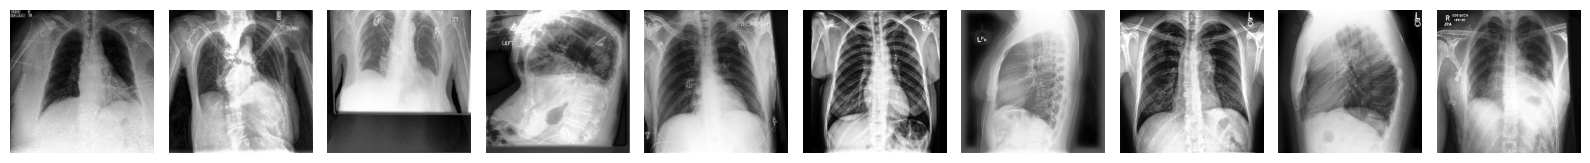

In [6]:
# Plot a sample of 10 images from the training set
import string
from tensorflow.keras.preprocessing.image import array_to_img

def plot_categories(train_images):
  fig, axes = plt.subplots(1, 10, figsize=(16, 15))
  axes = axes.flatten()
  letters = list(string.ascii_lowercase)

  for k in range(10):
    img = train_images[k]
    #img = np.expand_dims(img, axis=-1)
    img = array_to_img(img)
    ax = axes[k]
    ax.imshow(img, cmap="Greys_r")
    #ax.set_title(f"{letters[int(train_labels[k])]}")
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()

plot_categories(train_images)

# Creating DataFrames

In [7]:
train_df = train_df[['Path','Frontal/Lateral','Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']]
print(train_df.head())     # printing first five rows of the file
print(train_df.columns)
train_df = train_df.fillna(0)

                                                Path Frontal/Lateral  \
0  CheXpert-v1.0-small/train/patient00001/study1/...         Frontal   
1  CheXpert-v1.0-small/train/patient00002/study2/...         Frontal   
2  CheXpert-v1.0-small/train/patient00002/study1/...         Frontal   
3  CheXpert-v1.0-small/train/patient00002/study1/...         Lateral   
4  CheXpert-v1.0-small/train/patient00003/study1/...         Frontal   

   Cardiomegaly  Edema  Consolidation  Atelectasis  Pleural Effusion  
0           NaN    NaN            NaN          NaN               NaN  
1          -1.0   -1.0           -1.0         -1.0              -1.0  
2           NaN    NaN           -1.0          NaN               NaN  
3           NaN    NaN           -1.0          NaN               NaN  
4           NaN    1.0            NaN          NaN               NaN  
Index(['Path', 'Frontal/Lateral', 'Cardiomegaly', 'Edema', 'Consolidation',
       'Atelectasis', 'Pleural Effusion'],
      dtype='object')


In [8]:
# Counting number of uncertain findings in each pathology

print(f"Cardiomegaly -1: {len(train_df[train_df['Cardiomegaly'] == -1])}")
print(f"Edema -1: {len(train_df[train_df['Edema'] == -1])}")
print(f"Consolodation -1: {len(train_df[train_df['Consolidation'] == -1])}")
print(f"Atelectasis -1: {len(train_df[train_df['Atelectasis'] == -1])}")
print(f"Pleural -1: {len(train_df[train_df['Pleural Effusion'] == -1])}")

Cardiomegaly -1: 160
Edema -1: 226
Consolodation -1: 469
Atelectasis -1: 562
Pleural -1: 193


In [9]:
valid_df = valid_df[['Path','Frontal/Lateral','Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']]
print(valid_df.head())     # printing first five rows of the file
print(valid_df.columns)

                                                Path Frontal/Lateral  \
0  CheXpert-v1.0-small/valid/patient64541/study1/...         Frontal   
1  CheXpert-v1.0-small/valid/patient64542/study1/...         Frontal   
2  CheXpert-v1.0-small/valid/patient64542/study1/...         Lateral   
3  CheXpert-v1.0-small/valid/patient64543/study1/...         Frontal   
4  CheXpert-v1.0-small/valid/patient64544/study1/...         Frontal   

   Cardiomegaly  Edema  Consolidation  Atelectasis  Pleural Effusion  
0           1.0    0.0            0.0          0.0               0.0  
1           0.0    0.0            0.0          0.0               0.0  
2           0.0    0.0            0.0          0.0               0.0  
3           0.0    1.0            0.0          0.0               0.0  
4           0.0    0.0            0.0          0.0               0.0  
Index(['Path', 'Frontal/Lateral', 'Cardiomegaly', 'Edema', 'Consolidation',
       'Atelectasis', 'Pleural Effusion'],
      dtype='object')


# Train and Valid Labels

In [10]:
train_labels = np.array(train_df.drop(['Path', 'Frontal/Lateral'], axis=1))
print(len(train_labels))
print(train_labels.shape)
print(train_labels)

4075
(4075, 5)
[[ 0.  0.  0.  0.  0.]
 [-1. -1. -1. -1. -1.]
 [ 0.  0. -1.  0.  0.]
 ...
 [ 0.  1.  0. -1.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.]]


In [11]:
print(train_labels[0:5,:])

[[ 0.  0.  0.  0.  0.]
 [-1. -1. -1. -1. -1.]
 [ 0.  0. -1.  0.  0.]
 [ 0.  0. -1.  0.  0.]
 [ 0.  1.  0.  0.  0.]]


In [12]:
# Filtering the train_labels and keeping only those without -1 in atleast one column

mask = np.all(train_labels != -1.0, axis=1)
print(mask[0:5])
train_labels_filtered = train_labels[mask]
train_images_filtered = train_images[mask]
print(train_labels_filtered.shape)
print(train_images_filtered.shape)

[ True False False False  True]
(2967, 5)
(2967, 320, 320, 3)


In [13]:
train_labels_uncertain = train_labels[mask == False]
train_images_uncertain = train_images[mask == False]
print(train_labels_uncertain.shape)
print(train_images_uncertain.shape)

(1108, 5)
(1108, 320, 320, 3)


In [14]:
valid_labels = np.array(valid_df.drop(['Path', 'Frontal/Lateral'], axis=1))
print(len(valid_labels))

234


# Augementation

In [15]:
import tensorflow_datasets as tfds
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(
		height_factor=(-0.05, -0.15),
		width_factor=(-0.05, -0.15)),
])

# Prepare the data pipeline by setting batch size & buffer size using tf.data 

In [16]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_images_filtered, train_labels_filtered))
test_ds = tf.data.Dataset.from_tensor_slices((valid_images, valid_labels))
train_ds_uncertain = tf.data.Dataset.from_tensor_slices((train_images_uncertain, train_labels_uncertain))

In [17]:

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  #ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
              #num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)
    
  # Cache all datasets
  ds = ds.cache()

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [18]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
valid_ds = prepare(test_ds)
train_ds_uncertain = prepare(train_ds_uncertain, shuffle=True, augment=True)

# Build the Model

In [19]:
model = tf.keras.models.Sequential()

In [20]:
from tensorflow.keras.applications import DenseNet121

pre_trained_model = tf.keras.applications.densenet.DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=(320,320,3)
)

for layer in pre_trained_model.layers:
        layer.trainable=False

In [ ]:
pre_trained_model.summary()

In [21]:
model.add(pre_trained_model)

In [22]:
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
model.add(tf.keras.layers.Dense(units = 5, activation = 'sigmoid'))

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 10, 10, 1024)      7037504   
                                                                 
 flatten (Flatten)           (None, 102400)            0         
                                                                 
 dense (Dense)               (None, 128)               13107328  
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 20145477 (76.85 MB)
Trainable params: 13107973 (50.00 MB)
Non-trainable params: 7037504 (26.85 MB)
_________________________________________________________________


In [24]:
#Binary cross entropy of each label. So no really a binary classification problem but
#Calculating binary cross entropy for each label. _

model.compile(optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=0.0001,beta_1=0.9,beta_2=0.999),loss='binary_crossentropy', 
              metrics=['binary_accuracy', AUC(multi_label=True, num_labels=5)])

# Train the Model

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [25]:
import time

start = time.time()
history = model.fit(train_ds, epochs=3, validation_data=(valid_ds), batch_size=16)

print("Total time: ", time.time() - start, "seconds")

Epoch 1/3
93/93 [==============================] - 830s 9s/step - loss: 0.4859 - binary_accuracy: 0.8150 - auc: 0.6050 - val_loss: 0.5877 - val_binary_accuracy: 0.7427 - val_auc: 0.7261
Epoch 2/3
93/93 [==============================] - 724s 8s/step - loss: 0.4050 - binary_accuracy: 0.8296 - auc: 0.6803 - val_loss: 0.5677 - val_binary_accuracy: 0.7385 - val_auc: 0.7484
Epoch 3/3
93/93 [==============================] - 912s 10s/step - loss: 0.3956 - binary_accuracy: 0.8333 - auc: 0.7042 - val_loss: 0.5681 - val_binary_accuracy: 0.7444 - val_auc: 0.7504
Total time:  2477.2143380641937 seconds


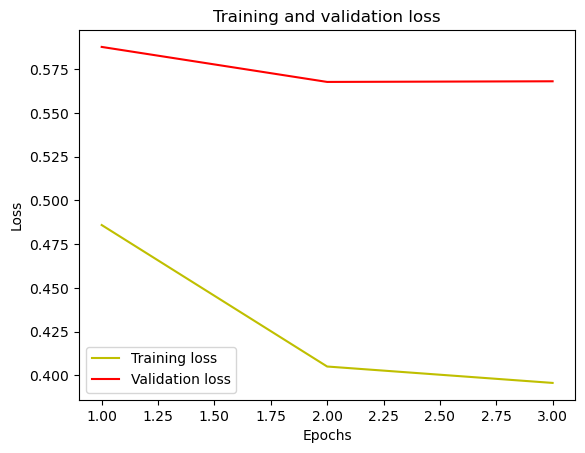

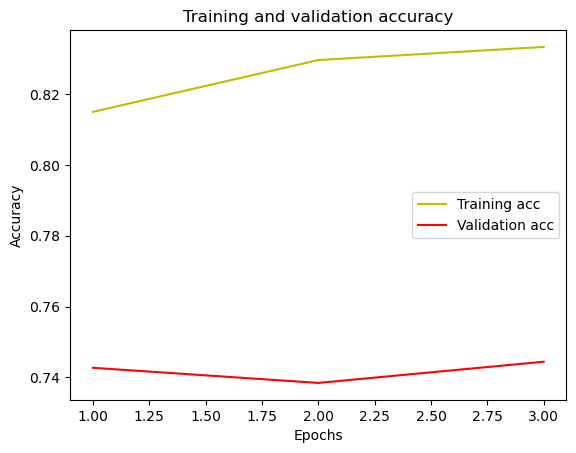

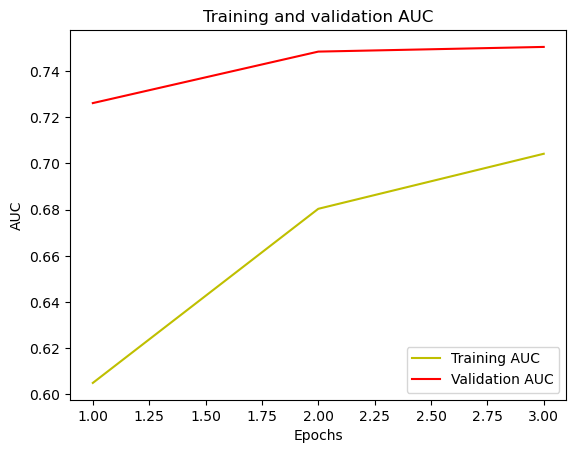

In [27]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

auc = history.history['auc']
val_auc = history.history['val_auc']
plt.plot(epochs, auc, 'y', label='Training AUC')
plt.plot(epochs, val_auc, 'r', label='Validation AUC')
plt.title('Training and validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()


# Evaluate the Model with Uncertain Labels

In [28]:
ds2= train_ds_uncertain
print("Test Accuracy: ", model.evaluate(ds2))

35/35 [==============================] - 299s 8s/step - loss: -0.1196 - binary_accuracy: 0.5650 - auc: 0.6121
Test Accuracy:  [-0.1195961982011795, 0.5649819374084473, 0.6121021509170532]


In [30]:
# Initialize empty lists to store predictions and actual labels
all_predictions_uncertain = []
all_actual_labels_uncertain = []

# Iterate over the dataset and collect predictions for individual images
for (images, labels) in train_ds_uncertain:
    predictions = model.predict(images)  # Get predictions for the current batch of images
    all_predictions_uncertain.extend(predictions)
    all_actual_labels_uncertain.extend(labels)

# Convert predictions to 1 if > 0.5, 0 otherwise
threshold = 0.5
rounded_predictions_uncertain = (np.array(all_predictions_uncertain) > threshold).astype(int)
actual_uncertain = np.array(all_actual_labels_uncertain).astype(int)

# Replacing only -1 and keeping 0 and 1s

# Print the actual labels and predictions for the first 10 images
print("Actual vs. Prediction for the first 10 images:")
for i in range(2):
    prediction_2 = rounded_predictions_uncertain[i].astype(int)
    actual_2= np.array(all_actual_labels_uncertain[i]).astype(int)
    print(f"Actual Labels: {actual_2}")
    print(f"Predictions  : {prediction_2}")
    print()

1/1 [==============================] - 4s 4s/step
Actual vs. Prediction for the first 10 images:
Actual Labels: [ 0  0  0 -1  0]
Predictions  : [0 0 0 0 0]

Actual Labels: [ 0  0 -1  0  1]
Predictions  : [0 0 0 0 1]



# Re-labeling uncertain labels

In [32]:
# Re-labeling each of the uncertainty labels without replacing instances of 0 and 1

mask = actual_uncertain == -1
print(mask.shape)
new_prediction = np.where(mask,rounded_predictions_uncertain,actual_uncertain)

print("Actual vs. Prediction for the first 10 images:")
for i in range(2):
    prediction_2 = new_prediction[i]
    actual_2= np.array(all_actual_labels_uncertain[i]).astype(int)
    print(f"Actual Labels: {actual_2}")
    print(f"New Predictions  : {prediction_2}")
    print()

(1108, 5)
Actual vs. Prediction for the first 10 images:
Actual Labels: [ 0  0  0 -1  0]
New Predictions  : [0 0 0 0 0]

Actual Labels: [ 0  0 -1  0  1]
New Predictions  : [0 0 0 0 1]



# Retraining the Model including the re-labeled data

In [33]:
#Uncertain images: train_images_uncertain
#New_labels = new_prediction

#Create a new dataset such that rows where the labels where u are present gets replaced with new_labels
#original labels = train_labels
#filtered_labels (without u) = train_labels_filtered
#labels for uncertain = train_labels_uncertain

new_labels = np.concatenate((train_labels_filtered, new_prediction), axis = 0)
print(new_labels.shape)
new_images = np.concatenate((train_images_filtered, train_images_uncertain), axis = 0)
print(new_images.shape)

(4075, 5)
(4075, 320, 320, 3)


In [34]:
# Create TensorFlow datasets
new_train_ds = tf.data.Dataset.from_tensor_slices((new_images, new_labels))

In [35]:
new_train_ds = prepare(new_train_ds, shuffle=True, augment=True)

In [36]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [37]:
import time

start = time.time()
history = model.fit(new_train_ds, epochs=3, validation_data=(valid_ds), batch_size=16,callbacks=[tensorboard_callback])

print("Total time: ", time.time() - start, "seconds")

Epoch 1/3
128/128 [==============================] - 1233s 10s/step - loss: 0.4063 - binary_accuracy: 0.8294 - auc: 0.6751 - val_loss: 0.6009 - val_binary_accuracy: 0.7513 - val_auc: 0.6547
Epoch 2/3
128/128 [==============================] - 1156s 9s/step - loss: 0.4072 - binary_accuracy: 0.8281 - auc: 0.6779 - val_loss: 0.6238 - val_binary_accuracy: 0.7504 - val_auc: 0.6643
Epoch 3/3
128/128 [==============================] - 1148s 9s/step - loss: 0.4046 - binary_accuracy: 0.8300 - auc: 0.6812 - val_loss: 0.5983 - val_binary_accuracy: 0.7504 - val_auc: 0.6914
Total time:  3556.5455186367035 seconds


In [38]:
%tensorboard --logdir logs/fit

# Evaluate the Model

In [39]:
ds= valid_ds
print("Test Accuracy: ", model.evaluate(ds))

8/8 [==============================] - 75s 9s/step - loss: 0.5983 - binary_accuracy: 0.7504 - auc: 0.6914
Test Accuracy:  [0.5983429551124573, 0.7504273653030396, 0.6914038062095642]


In [40]:
# Initialize empty lists to store predictions and actual labels
all_predictions = []
all_actual_labels = []

# Iterate over the dataset and collect predictions for individual images
for (images, labels) in valid_ds:
    predictions = model.predict(images)  # Get predictions for the current batch of images
    all_predictions.extend(predictions)
    all_actual_labels.extend(labels)

# Convert predictions to 1 if > 0.5, 0 otherwise
threshold = 0.5
rounded_predictions = (np.array(all_predictions) > threshold).astype(int)
actual = np.array(all_actual_labels).astype(int)


# Print the actual labels and predictions for the first 10 images
print("Actual vs. Prediction for the first 10 images:")
for i in range(2):
    prediction_2 = rounded_predictions[i]
    actual_2= np.array(all_actual_labels[i]).astype(int)
    print(f"Actual Labels: {actual_2}")
    print(f"Predictions  : {prediction_2}")
    print()

1/1 [==============================] - 3s 3s/step
Actual vs. Prediction for the first 10 images:
Actual Labels: [1 0 0 0 0]
Predictions  : [0 0 0 0 0]

Actual Labels: [0 0 0 0 0]
Predictions  : [0 0 0 0 0]



# AUC and ROC curve

In [49]:
# Actual vs Predicted per Pathology

column = 4      # 0-Cardiomegaly, 1-Edema, 2-Consolidation, 3-Atelectasis, 4-Pleural Effusion 

pred_pathology = rounded_predictions[:,column]
actual_pathology = actual[:,column]

print(f"pred_pathology: {pred_pathology}")
print(f"actual_pathology: {actual_pathology}")

pred_pathology: [0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0
 0 0 1 0 1 1 1 0 0 0 0 1 1 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0
 0 1 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0
 1 0 1 1 0 0 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 1
 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0
 1 0 0 0 0 1 1 0 0 1 0 1]
actual_pathology: [0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0
 0 1 0 0 0 0 0 0 0 1 1 0 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 0 0 1 1 0 1 1 1 1 0
 1 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 1 1 0 1 1 0 1 0 0 1 1 1 1 0 0 0 1 1 1 1 1
 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 1 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1]


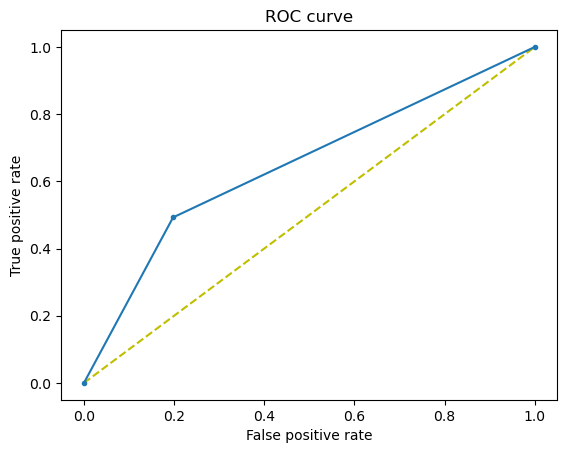

In [50]:
# ROC curve

fpr, tpr, thresholds = roc_curve(actual_pathology, pred_pathology)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

In [51]:
# Confusion Matrix

cm=confusion_matrix(actual_pathology, pred_pathology)  
print(cm)

[[134  33]
 [ 34  33]]


In [52]:
# Finding the Ideal Threshold

i = np.arange(len(tpr)) 
roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'thresholds' : pd.Series(thresholds, index=i)})
ideal_roc_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]  #Locate the point where the value is close to 0
print("Ideal threshold is: ", ideal_roc_thresh['thresholds']) 

Ideal threshold is:  1    1.0
Name: thresholds, dtype: float64


In [53]:
# AUC

from sklearn.metrics import auc
auc_value = auc(fpr, tpr)
print("Area under curve, AUC = ", auc_value)

Area under curve, AUC =  0.6474662615068371
